# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

#Loading Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/umulsy/Ads_Click_Prediction/refs/heads/main/ads_dataset.csv')
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
3,7808,User7808,26.0,Female,Desktop,Top,NaN,NaN,1
4,5065,User5065,40.0,Male,Mobile,Side,NaN,Evening,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8337 non-null   int64  
 1   full_name         8337 non-null   object 
 2   age               4458 non-null   float64
 3   gender            3644 non-null   object 
 4   device_type       6674 non-null   object 
 5   ad_position       6683 non-null   object 
 6   browsing_history  4329 non-null   object 
 7   time_of_day       6672 non-null   object 
 8   click             8337 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 586.3+ KB


Terdapat 6 data bertipe object berarti terdapat 6 categorical feature. 2 bertipe angka atau integer (int) 1 bertipe desimal (float)

<div class="alert alert-success" style="background-color: #f5e6c8; border-color: #e0c097; padding: 20px;">
    <h1 align="center" style="color:black; font-size: 28px; font-family: Arial, sans-serif; margin-bottom: 10px;">Exploratory Data Analysis
    </h1>
</div>

In [ ]:
df = df.drop(columns=['id'])

In [ ]:
df.describe(include='all')

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
count,8337,4458.000000,3644,6674,6683,4329,6672,8337.000000
unique,3379,NaN,2,3,3,5,4,NaN
top,User1171,NaN,Female,Desktop,Bottom,Entertainment,Morning,NaN
freq,25,NaN,1834,2367,2376,991,1786,NaN
mean,NaN,40.080081,NaN,NaN,NaN,NaN,NaN,0.653472
std,NaN,13.245278,NaN,NaN,NaN,NaN,NaN,0.475892
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,39.000000,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,1.000000


In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = {col: df[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
        print(f"{col}: {unique_count} unique values")
        print(df[col].unique(), "\n")

full_name: 3379 unique values
['User670' 'User3044' 'User5418' ... 'User7843' 'User3914' 'User3056'] 

gender: 2 unique values
[nan 'Male' 'Female'] 

device_type: 3 unique values
['Desktop' nan 'Mobile' 'Tablet'] 

ad_position: 3 unique values
['Top' nan 'Side' 'Bottom'] 

browsing_history: 5 unique values
['Shopping' nan 'Entertainment' 'Education' 'News' 'Social Media'] 

time_of_day: 4 unique values
['Afternoon' nan 'Evening' 'Morning' 'Night'] 



In [ ]:
missing_df = df.isna().mean() * 100
missing_df = missing_df[missing_df > 5].sort_values(ascending=False)
print("Columns with more than 5% missing values:")
print(missing_df)


Columns with more than 5% missing values:
gender              56.291232
browsing_history    48.074847
age                 46.527528
time_of_day         19.971213
device_type         19.947223
ad_position         19.839271
dtype: float64


In [ ]:
import plotly.express as px
def plot_pie_chart(df, column_name):
    value_counts = df[column_name].value_counts(dropna=False)
    value_counts = value_counts.reset_index()
    value_counts.columns = [column_name, 'count']

    fig = px.pie(value_counts, names=column_name, values='count',
                 title=f'{column_name} Distribution (Including Unknown)',
                 color_discrete_sequence=px.colors.qualitative.T10,
                 hole=0.4)

    fig.update_traces(textinfo='percent+label')

    fig.update_layout(title_x=0.5)

    fig.show()

categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('full_name', errors='ignore')
for col in categorical_columns:
    plot_pie_chart(df, col)

In [ ]:
# Cek duplikasi
duplicate_rows = df[df.duplicated()]
print("Jumlah baris duplikat:", len(duplicate_rows))

Jumlah baris duplikat: 2384


<div style="border-radius:10px; border:#e0c097 solid 2px; padding: 15px; background-color: white; font-size:100%; text-align:left"> <h3 align="center" style="color: #d4a017;">Data Cleaning</h3>

- The proportion of recurring users and first-time users among the 4,000 unique users was analyzed.
- First-time users consist of 3,500 individuals, each contributing one record, none of whom clicked on the ads.
- Recurring users include 500 individuals who collectively contributed 6,500 records, and all of these users clicked on the ads.

In [ ]:
df_type_user = df.copy()
user_counts = df_type_user['full_name'].value_counts()

df_type_user['user_type'] = df_type_user['full_name'].apply(lambda x: 'First Time Users' if user_counts[x] == 1 else 'Recurring Users')

In [ ]:
recurring_users = df_type_user[df_type_user.duplicated(subset=['full_name'], keep=False)]
first_time_users = df_type_user.drop_duplicates(subset=['full_name'], keep=False)

In [ ]:
recurring_users.describe(include='all')

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
count,5422,2882.000000,2397,4333,4367,2756,4352,5422.0,5422
unique,464,NaN,2,3,3,5,4,NaN,1
top,User1171,NaN,Female,Desktop,Bottom,Entertainment,Morning,NaN,Recurring Users
freq,25,NaN,1206,1593,1630,675,1192,NaN,5422
mean,NaN,39.365024,NaN,NaN,NaN,NaN,NaN,1.0,NaN
std,NaN,13.022529,NaN,NaN,NaN,NaN,NaN,0.0,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
25%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
50%,NaN,38.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN
75%,NaN,51.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [ ]:
first_time_users.describe(include='all')

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
count,2915,1576.000000,1247,2341,2316,1573,2320,2915.000000,2915
unique,2915,NaN,2,3,3,5,4,NaN,1
top,User5065,NaN,Female,Mobile,Side,Social Media,Evening,NaN,First Time Users
freq,1,NaN,628,815,785,327,602,NaN,2915
mean,NaN,41.387690,NaN,NaN,NaN,NaN,NaN,0.008919,NaN
std,NaN,13.550098,NaN,NaN,NaN,NaN,NaN,0.094036,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,29.750000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
50%,NaN,42.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
75%,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


In [ ]:
feature_counts = df_type_user.groupby(['user_type', 'click']).size().reset_index(name='count')

feature_counts['click'] = feature_counts['click'].map({0: 'No Click', 1: 'Click'})

fig = px.bar(feature_counts,
             x='user_type', y='count', color='click',
             title='Ad Clicks by User Type (First Time vs Recurring)',
             labels={"user_type": "User Type", "count": "Number of Clicks", "click": "Click Status"},
             color_discrete_sequence=px.colors.qualitative.T10,
             text='count',
             barmode="group")

fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,
    xaxis_title="User Type",
    yaxis_title="Number of Clicks",
    legend_title="Click Status",
    bargap=0.5,
    bargroupgap=0.1
)

fig.show()

In [ ]:
recurring_users.sort_values(by='full_name', ascending=True).head(30)

,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,user_type
7055,User1020,NaN,NaN,Mobile,NaN,Education,Morning,1,Recurring Users
248,User1020,NaN,NaN,NaN,Side,NaN,Morning,1,Recurring Users
163,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Recurring Users
3003,User1020,NaN,NaN,NaN,Side,Education,Morning,1,Recurring Users
6559,User1020,NaN,NaN,NaN,Side,Education,NaN,1,Recurring Users
2186,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Recurring Users
7216,User1020,NaN,NaN,NaN,Side,Education,Morning,1,Recurring Users
2302,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Recurring Users
3014,User1020,NaN,NaN,Mobile,Side,Education,Morning,1,Recurring Users
888,User1020,NaN,NaN,Mobile,Side,NaN,Morning,1,Recurring Users


In [ ]:
df.update(df.groupby('full_name').transform(lambda x: x.ffill().bfill()))
df = df.drop(columns=['full_name'])

<div style="border-radius:10px; border:#e0c097 solid 2px; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center" style="color: #d4a017;">Handling Other Missing Values</h3>

- An "Unknown" category was introduced to handle missing values.
- Imputation methods such as mode, mean, or random filling based on the original distribution were deliberately avoided.
- This approach prevents over-analyzing the original data while preserving the information carried by missing values.
- Additionally, it helps mitigate model bias and reduces the risk of overfitting.


In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col].fillna('Unknown', inplace=True)

In [ ]:
from sklearn.impute import KNNImputer
import pandas as pd
def knn_impute(df, n_neighbors=5):
    df_encoded = df.copy()

    category_mappings = {}
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(df[col].astype('category').cat.categories))


    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)


    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(category_mappings[col])

    return df_imputed

df_imputed = knn_impute(df, n_neighbors=5)


df = df_imputed

In [ ]:
print(df.isna().sum())

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64


<div class="alert alert-success" style="background-color: #f5e6c8; border-color: #e0c097; padding: 20px;">
    <h1 align="center" style="color:black; font-size: 28px; font-family: Arial, sans-serif; margin-bottom: 10px;">Data Visualization
    </h1>
</div>

In [ ]:
age_bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
age_labels = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64']
df_visualization = df.copy()
df_visualization['age_group'] = pd.cut(df_visualization['age'], bins=age_bins, labels=age_labels, right=False)


click_counts = df_visualization.groupby(['age_group', 'click']).size().reset_index(name='count')

click_counts['click'] = click_counts['click'].map({0: 'No Click', 1: 'Click'})

fig = px.bar(
    click_counts,
    x='age_group',
    y='count',
    color='click',
    title='Age Group Distribution of Clicks vs No Clicks',
    labels={'age_group': 'Age group', 'count': 'Count', 'click': 'Click Status'},
    text='count',
    color_discrete_sequence=px.colors.qualitative.T10,
    category_orders={'age_group': age_labels}
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Age group',
    yaxis_title='Count',
    legend_title='Click Status',
    title_x=0.5
)

fig.show()


In [ ]:
feature_counts = df.groupby([df['click'].map({1: 'Click', 0: 'No Click'}), 'ad_position']).size().reset_index(name='count')

total_count = feature_counts['count'].sum()
feature_counts['percent'] = feature_counts['count'] / total_count * 100

fig = px.sunburst(feature_counts, path=['click', 'ad_position'], values='count',
                 color='count', color_continuous_scale='Teal',
                 title='Ad Clicks by Ad position')

fig.update_traces(
    textinfo='label+percent entry',
    texttemplate='<b>%{label}</b><br>%{percentEntry:.2%}'
)

fig.update_layout(title_text='Ad Clicks by Ad position',
                  title_x=0.5, width=900, height=600)

fig.show()

In [ ]:
feature_counts = df.groupby([df['click'].map({1: 'Click', 0: 'No Click'}), 'time_of_day']).size().reset_index(name='count')

total_count = feature_counts['count'].sum()
feature_counts['percent'] = feature_counts['count'] / total_count * 100

fig = px.sunburst(feature_counts, path=['click', 'time_of_day'], values='count',
                 color='count', color_continuous_scale='Teal',
                 title='Ad Clicks by time_of_day')

fig.update_traces(
    textinfo='label+percent entry',
    texttemplate='<b>%{label}</b><br>%{percentEntry:.2%}'
)

fig.update_layout(title_text='Ad Clicks by Time of Day ',
                  title_x=0.5, width=900, height=600)

fig.show()

In [ ]:
feature_counts = df.groupby(['device_type', 'ad_position'])['click'].size().reset_index(name='click')
fig = px.bar(feature_counts,
             x='device_type', y='click', color='ad_position',
             title='Ad Clicks by Device Type and Ad Position',
             labels={"device_type": "Device Type", "click": "Number of Clicks", "ad_position": "Ad Position"},
             color_discrete_sequence=px.colors.qualitative.T10,
             text='click',
             barmode="group")
fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,
    xaxis_title="Device Type",
    yaxis_title="Number of Clicks",
    legend_title="Ad Position",
    bargap=0.5,
    bargroupgap=0.1
)

fig.show()

In [ ]:
!pip install dython

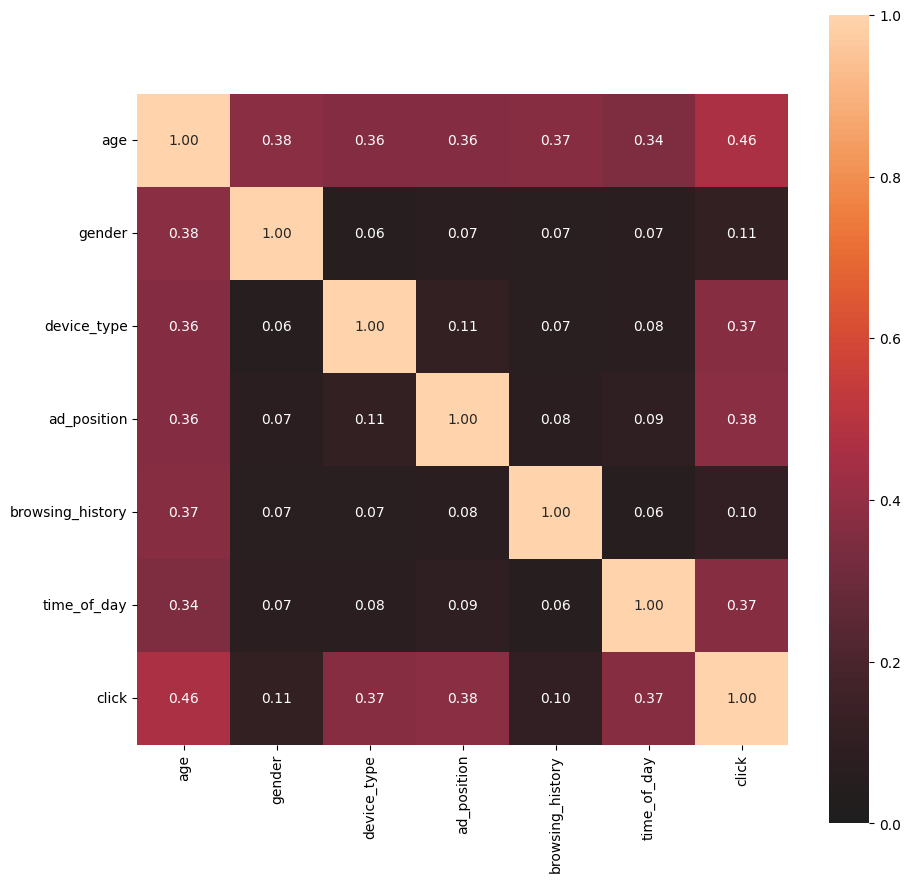

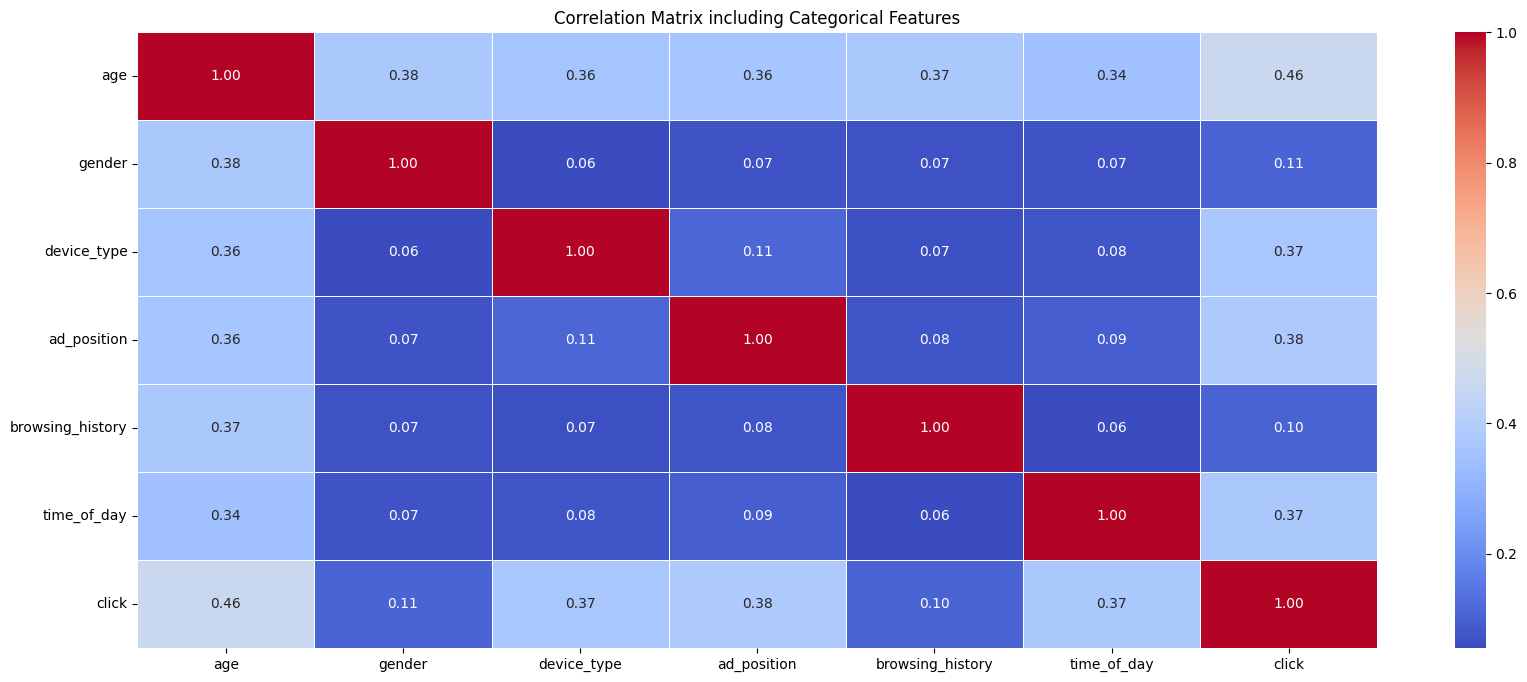

In [ ]:
from dython.nominal import associations
associations_df = associations(df, nominal_columns='all', plot=False)

corr_matrix = associations_df['corr']

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

<div class="alert alert-success" style="background-color: #f5e6c8; border-color: #e0c097; padding: 20px;">
    <h1 align="center" style="color:black; font-size: 28px; font-family: Arial, sans-serif; margin-bottom: 10px;">Model Building & Training
    </h1>
</div>

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Misal `df` adalah DataFrame kita
# Identifikasi kolom bertipe `object`
object_columns = df.select_dtypes(include='object').columns

# Inisialisasi OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Terapkan OneHotEncoder pada kolom bertipe object
encoded_data = encoder.fit_transform(df[object_columns])

# Membuat DataFrame hasil encoding dengan nama kolom baru yang sesuai
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(object_columns))

# Menggabungkan hasil encoding dengan kolom numerik lainnya
df_final = pd.concat([df.drop(columns=object_columns).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Tampilkan DataFrame hasil
print(df_final.head())

    age  click  gender_Female  gender_Male  gender_Unknown  \
0  22.0    1.0            0.0          0.0             1.0   
1  34.0    1.0            0.0          1.0             0.0   
2  34.0    1.0            0.0          1.0             0.0   
3  26.0    1.0            1.0          0.0             0.0   
4  40.0    0.0            0.0          1.0             0.0   

   device_type_Desktop  device_type_Mobile  device_type_Tablet  \
0                  1.0                 0.0                 0.0   
1                  1.0                 0.0                 0.0   
2                  0.0                 1.0                 0.0   
3                  1.0                 0.0                 0.0   
4                  0.0                 1.0                 0.0   

   device_type_Unknown  ad_position_Bottom  ...  \
0                  0.0                 0.0  ...   
1                  0.0                 0.0  ...   
2                  0.0                 0.0  ...   
3                  0.0    

In [ ]:
from sklearn.model_selection import train_test_split

X = df_final.drop('click', axis=1)
y = df_final['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=94)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier # Import the classifier instead of regressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
# Create a pipeline to combine preprocessing and model training
# Initialize and train K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Make predictions on the test data
y_predKNN = knn.predict(X_test)

# Calculate and print accuracy
accuracyKNN = accuracy_score(y_test, y_predKNN)
print(f'Accuracy: {accuracyKNN:.2f}')

Accuracy: 0.83


In [ ]:
y_test = y_test.astype(int)
y_predKNN = y_predKNN.astype(int)

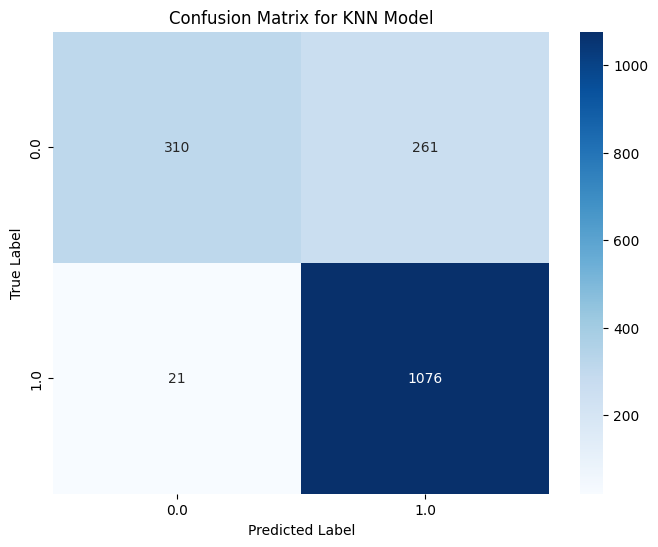

In [ ]:
from sklearn.metrics import confusion_matrix

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_predKNN)

# Menampilkan confusion matrix dengan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model')
plt.show()


In [ ]:
# Build Model Random Forest
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier

# buat model prediksi
RF = RandomForestClassifier(n_estimators=50, max_depth=16, random_state=50, n_jobs=-1)# Change to Classifier
RF.fit(X_train, y_train)

# make prediction
y_predRF = RF.predict(X_test)

#cek akurasi
accuracyRF = accuracy_score(y_test, y_predRF)
print(f'Accuracy: {accuracyRF:.2f}')

Accuracy: 0.96


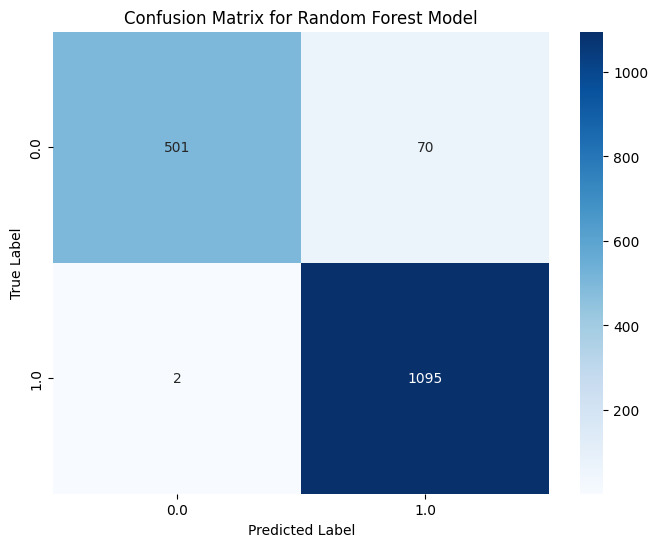

In [ ]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_predRF)

# Menampilkan confusion matrix dengan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# Build model Xgboost
import xgboost as xgb

# buat model prediksi
xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1) # Change to Classifier
xgb_model.fit(X_train, y_train)

# make prediction
y_predXGB = xgb_model.predict(X_test)

#cek akurasi
accuracyXGB = accuracy_score(y_test, y_predXGB)
print(f'Accuracy: {accuracyXGB:.2f}')

Accuracy: 0.96


In [ ]:
# evaluate model
xgb_model.score(X_test, y_test)

0.9550359712230215

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93       571
           1       0.94      1.00      0.97      1097

    accuracy                           0.96      1668
   macro avg       0.97      0.94      0.95      1668
weighted avg       0.96      0.96      0.95      1668

Confusion Matrix:
 [[ 500   71]
 [   4 1093]]


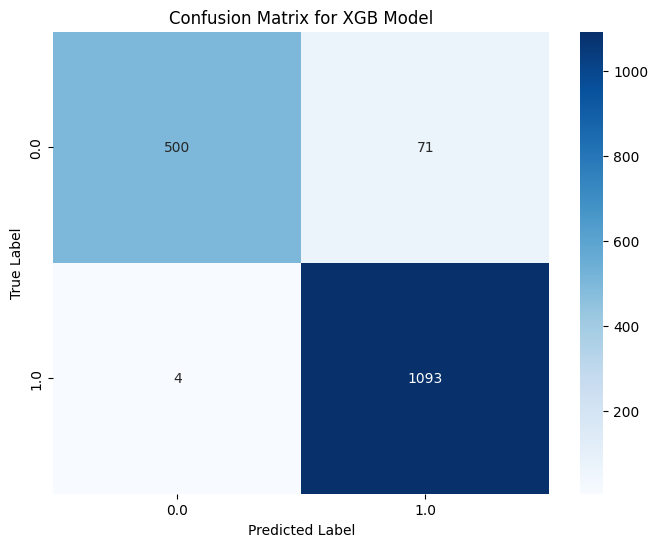

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_predXGB))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predXGB))
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_test, y_predXGB)

# Menampilkan confusion matrix dengan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGB Model')
plt.show()

In [ ]:
# Model Comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
models = {"KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "XGBoost": xgb.XGBClassifier()}

# function to fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        #fit the model
        model.fit(X_train, y_train)
        #append the score of the model
        model_scores[name] = model.score(X_test, y_test)
    return model_scores


In [ ]:
model_scores = fit_and_score(models=models,
                             X_train = X_train,
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)
model_scores

{'KNN': 0.8866906474820144,
 'Random Forest': 0.9592326139088729,
 'XGBoost': 0.9382494004796164}

In [ ]:
model_compare = pd.DataFrame(model_scores, index=["accuracy", 'precission', 'f1 score', 'recall'])
model_compare

,KNN,Random Forest,XGBoost
accuracy,0.886691,0.959233,0.938249
precission,0.886691,0.959233,0.938249
f1 score,0.886691,0.959233,0.938249
recall,0.886691,0.959233,0.938249


<Axes: >

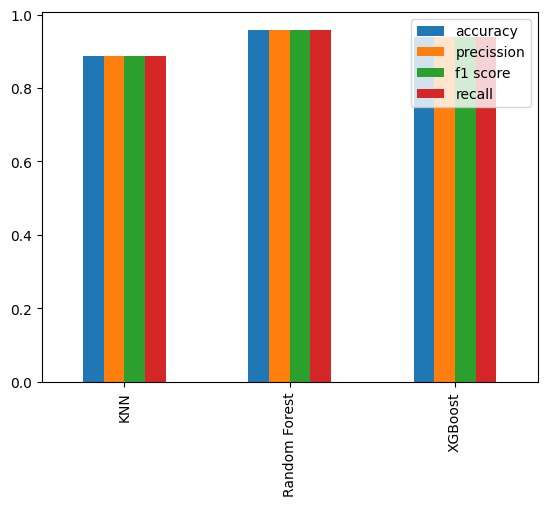

In [ ]:
model_compare.T.plot.bar()

In [ ]:
#set train size
#316 x 80% = 252 (20% for validation)
train_sizes = [1, 20, 40, 50, 100, 150, 252]

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import learning_curve

def learn_curve_plot(estimator, x, y, cv, train_sizes):
  train_sizes, train_scores, validation_scores = learning_curve(estimator,X=X,y=y, train_sizes= train_sizes, cv=cv)
  train_scores_mean = train_scores.mean(axis=1)
  validation_scores_mean = validation_scores.mean(axis=1)

  #Print
  print('Mean training scores\n\n', pd.Series(train_scores_mean, index=train_sizes))
  print('\n', '-' * 20) # separator
  print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index=train_sizes))

  # Use seaborn style.
  # Use sns.set_theme() instead of plt.style.use('seaborn')
  sns.set_theme()
  # sns.set_style("whitegrid")  # Alternatively, you can use sns.set_style to set a specific seaborn style before plotting.

  plt.plot(train_sizes, train_scores_mean, label = 'Training error')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
  plt.ylabel('Accuracy', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  plt.title('Learning Curve', fontsize = 18, y = 1.03)
  plt.legend()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 271, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 834, in kneighbors
    raise ValueErro

Mean training scores

 1           NaN
20     0.880000
40     0.790000
50     0.796000
100    0.732000
150    0.665333
252    0.721429
dtype: float64

 --------------------

Mean validation scores

 1           NaN
20     0.592082
40     0.603113
50     0.616901
100    0.635127
150    0.600337
252    0.644960
dtype: float64


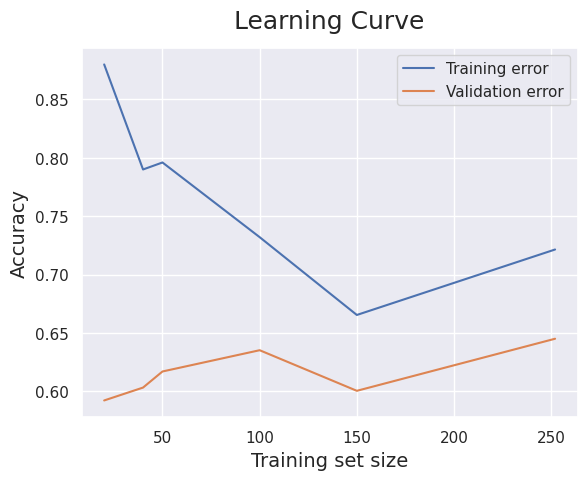

In [ ]:
# Learning Curve KNN
learn_curve_plot(estimator=knn, x=X, y=y, cv=5, train_sizes=train_sizes)

Mean training scores

 1      1.0
20     1.0
40     1.0
50     1.0
100    1.0
150    1.0
252    1.0
dtype: float64

 --------------------

Mean validation scores

 1      0.592082
20     0.578406
40     0.627098
50     0.679512
100    0.729649
150    0.784100
252    0.784337
dtype: float64


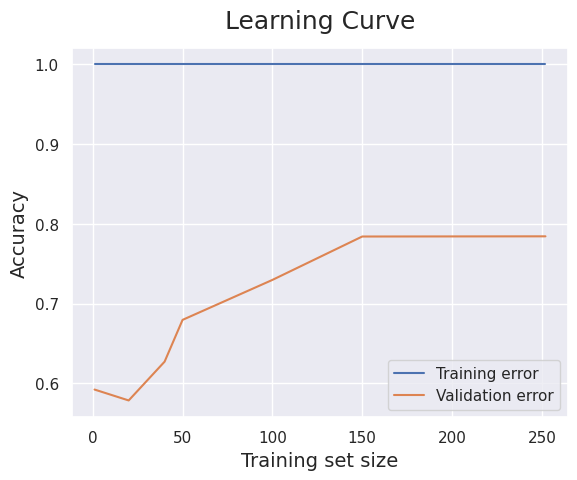

In [ ]:
# Learning Curve Random Forest
learn_curve_plot(estimator=RF, x=X, y=y, cv=5, train_sizes=train_sizes)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


4 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1.]




Mean training scores

 1           NaN
20     0.920000
40     0.980000
50     0.968000
100    0.992000
150    1.000000
252    0.999206
dtype: float64

 --------------------

Mean validation scores

 1           NaN
20     0.594122
40     0.622896
50     0.626973
100    0.715011
150    0.738156
252    0.786497
dtype: float64


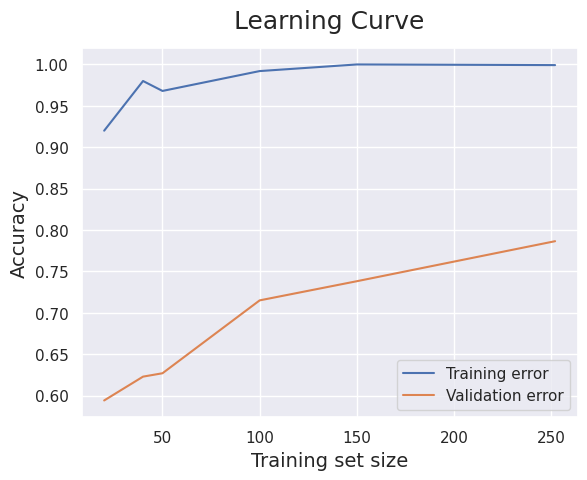

In [ ]:
# Learning Curve Xgboost
learn_curve_plot(estimator=xgb_model, x=X, y=y, cv=5, train_sizes=train_sizes)

In [ ]:
df_final.head()

,age,click,gender_Female,gender_Male,gender_Unknown,device_type_Desktop,device_type_Mobile,device_type_Tablet,device_type_Unknown,ad_position_Bottom,...,browsing_history_Entertainment,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,browsing_history_Unknown,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,time_of_day_Unknown
0,22.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,34.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,34.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,40.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_final.isna().sum()

,0
age,0
click,0
gender_Female,0
gender_Male,0
gender_Unknown,0
device_type_Desktop,0
device_type_Mobile,0
device_type_Tablet,0
device_type_Unknown,0
ad_position_Bottom,0
